# Radio Message Understanding: Dual Model Approach

**Advanced Text Understanding for F1 Strategy**

For our F1 strategic decision system, we need to extract structured information from radio messages to feed our logic agent. Building on our successful sentiment analysis model, we'll implement a comprehensive approach to understand both the intent and specific entities in team radio communications.

---

## 1. Intent Classification with RoBERTa

We'll fine-tune a RoBERTa model (similar to our sentiment analysis model) to classify radio messages into specific intent categories:

- **Order:** Direct instructions to the driver ("Box this lap", "Push now")
- **Information:** Factual updates about race conditions ("Hamilton is 2 seconds behind")
- **Question:** Queries requiring driver input ("How are the tyres feeling?")
- **Warning:** Alerts about potential issues ("Watch your fuel consumption")
- **Strategy:** Long-term planning elements ("We're looking at Plan B")
- **Problem**: messages that ensures actual problems ("My left wing is broken")

This classification will help our logic agent understand the purpose of each communication and respond appropriately.

---

## 2. Custom NER with SpaCy for F1-Specific Entities

We'll train a specialized SpaCy model to identify key racing entities in the text:

- **DRIVER:** References to specific drivers
- **TEAM:** Team names and references
- **TYRES:** Tyre compounds and conditions (soft, medium, hard, intermediate, wet)
- **LAPNUM:** References to specific laps
- **TIME_GAP:** Time differences mentioned in seconds
- **STRATEGY:** Strategy terms (undercut, overcut, Plan A/B)
- **TRACK_STATUS:** Track conditions (DRS, safety car, VSC)

---

## Complete Radio Understanding Pipeline

By combining these new models with our existing sentiment analysis:

$Radio Message → [Sentiment Analysis] → [Intent Classification] → [Entity Extraction] → Structured Data$


The final output should be comprehensive structured data like:

```json
{
  "message": "Box this lap for softs, Hamilton is catching up",
  "analysis": {
    "sentiment": "neutral",
    "intent": "order",
    "entities": {
      "action": "box",
      "lap": "current",
      "tyres": "soft",
      "driver_ref": "Hamilton",
      "situation": "catching up"
    }
  }
}
````
This rich, structured information will enable my logic agent to make sophisticated race strategy decisions based on radio communications.

---

# 1. But first, I need to relabel the data.

My data is not labeled for making intention recognition. Therefore, the first thing I need to do is label again the data in a different csv for the intention categories.

Therefore, my first approach will be the following:

## Step 1: Define Intent Categories
First, we need to establish clear definitions for each intent category:

1. **ORDER**: Direct instructions requiring action from the driver

    Examples: "Box this lap", "Push now", "Stay out"


2. **INFORMATION**: Factual updates about race conditions

    Examples: "Hamilton is 2 seconds behind", "Lap time 1:34.5", "You're P4"


3. **QUESTION**: Queries requiring driver input

    Examples: "How are the tyres feeling?", "Do you want to pit this lap?", "Are you happy with the balance?"


4. **WARNING**: Alerts about potential issues or cautions

    Examples: "Watch your fuel consumption", "Yellow flag in sector 2", "VSC deployed"


5. **STRATEGY**: Long-term planning elements or discussions

    Examples: "We're looking at Plan B", "Target plus 5 on tyre management", "Consider an undercut"

6. **PROBLEM**: driver-reported issues:

    Examples: "Losing grip on the rear", "My tires are dead".

---

## Step 1: Import Necessary Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import datetime

---

## Step 2: Manual Labeling Interface

I will make with Jupyet widgets a simple interface that helps me label the data. For this task, I´ll use `radio_filtered.csv`

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from ipywidgets import widgets, Layout
import ipywidgets as widgets

# Load the full radio messages dataset
df = pd.read_csv('../../outputs/week4/radio_clean/radio_filtered.csv')

# Check the columns to see which one contains the radio messages
print("Columns in the dataset:", df.columns.tolist())

# Assuming there's a column containing the radio messages, we'll use that
message_column = 'radio_message'  # Adjust this based on the actual column name

# Use the entire dataset instead of a sample
intent_df = pd.DataFrame({
    'message': df[message_column].values,
    'intent': [""] * len(df)
})

# Reset the index to make sure we have 0-based sequential indices
intent_df = intent_df.reset_index(drop=True)

print(f"Total messages to label: {len(intent_df)}")

# Define the intent categories including the PROBLEM category
intent_categories = ["ORDER", "INFORMATION", "QUESTION", "WARNING", "STRATEGY", "PROBLEM"]

# Create a stateful counter for tracking which message we're on
current_index = widgets.IntText(value=0, description='Current:', layout=Layout(display='none'))

# Output widget for displaying the labeling interface
output = widgets.Output()

################################ WARNING: ONLY UNCOMMENT FOR LABELING THE DATA ######################################
# # Function to save the dataframe
# def save_dataframe():
#     # Only save rows that have been labeled
#     labeled_df = intent_df[intent_df['intent'] != ""]
#     labeled_df.to_csv('../../outputs/week4/radio_clean/intent_labeled_data.csv', index=False)
#     with output:
#         print(f"Dataset saved! {len(labeled_df)} labeled messages.")
        
#         if len(labeled_df) > 0:
#             # Show distribution of intents
#             plt.figure(figsize=(10, 6))
#             sns.countplot(y='intent', data=labeled_df)
#             plt.title('Distribution of Intent Categories')
#             plt.tight_layout()
#             plt.show()
######################################################################################################################
# Function to display the current message
def display_current_message():
    with output:
        output.clear_output()
        
        if current_index.value >= len(intent_df):
            current_index.value = len(intent_df) - 1
            
        if current_index.value < 0:
            current_index.value = 0
            
        idx = current_index.value
        print(f"Message {idx+1}/{len(intent_df)}:")
        print(f"\"{intent_df.iloc[idx]['message']}\"")
        
        # Show current label if any
        current_intent = intent_df.iloc[idx]['intent']
        if current_intent:
            print(f"\nCurrent label: {current_intent}")
        
        # Display intent category descriptions for reference
        print("\nIntent Categories:")
        print("ORDER: Direct instructions requiring action (Box this lap, Push now)")
        print("INFORMATION: Factual updates (Hamilton is 2 seconds behind)")
        print("QUESTION: Queries requiring driver input (How are the tyres feeling?)")
        print("WARNING: Alerts about external issues (Yellow flag in sector 2)")
        print("STRATEGY: Long-term planning elements (We're looking at Plan B)")
        print("PROBLEM: Driver-reported issues (Losing grip on the rear)")
        
        # Count labeled messages
        labeled_count = (intent_df['intent'] != "").sum()
        print(f"\nProgress: {labeled_count}/{len(intent_df)} messages labeled ({labeled_count/len(intent_df)*100:.1f}%)")

# Function to handle intent button clicks
def on_intent_button_clicked(b, intent=None):
    idx = current_index.value
    intent_df.at[idx, 'intent'] = intent
    # Automatically move to next message after labeling
    current_index.value += 1
    display_current_message()

# Navigation button handlers
def on_prev_clicked(b):
    current_index.value -= 1
    display_current_message()
    
def on_next_clicked(b):
    current_index.value += 1
    display_current_message()

# Create buttons for each intent category
intent_buttons = []
for intent in intent_categories:
    button = widgets.Button(
        description=intent,
        button_style='', 
        layout=Layout(width='150px', height='40px')
    )
    
    button.on_click(lambda b, intent=intent: on_intent_button_clicked(b, intent))
    intent_buttons.append(button)

# Create navigation buttons
prev_button = widgets.Button(
    description='« Previous',
    button_style='info',
    layout=Layout(width='120px', height='40px')
)
prev_button.on_click(on_prev_clicked)

next_button = widgets.Button(
    description='Next »',
    button_style='info',
    layout=Layout(width='120px', height='40px')
)
next_button.on_click(on_next_clicked)

# Create save button
save_button = widgets.Button(
    description='💾 Save Progress',
    button_style='success',
    layout=Layout(width='150px', height='40px')
)

######################### WARNING: ONLY UNCOMMENT FOR SAVING NEW LABELED DATA ###############################
# save_button.on_click(lambda b: save_dataframe())
#############################################################################################################



# Create button rows
intent_row1 = widgets.HBox(intent_buttons[:3], layout=Layout(justify_content='center'))
intent_row2 = widgets.HBox(intent_buttons[3:], layout=Layout(justify_content='center'))
nav_row = widgets.HBox([prev_button, save_button, next_button], layout=Layout(justify_content='center'))

# Assemble the UI
vbox = widgets.VBox([
    current_index,
    output,
    intent_row1,
    intent_row2,
    nav_row
])

# Initialize the display
display(vbox)
display_current_message()

Columns in the dataset: ['driver', 'radio_message', 'sentiment']
Total messages to label: 529


---

## Step 3: Training an intent classifier

Next steps are:

1. *Splitting `intent_labeled_data.csv` into train/validation/test sets*.

2. *Tokenize the dataset, adjusting the maximum tokens*

3. *Download a pre-trained RoBERTa model and apply fine-tuning*.

4. Try some runs, see how the performance improves and save the best model.

The workflow here is quite similar to the one of `N03_bert_sentiment.ipynb`, but now predicting 6 classes instead of only 3.


##### Loading the dataset and applying mapping

In [4]:
df = pd.read_csv('../../outputs/week4/radio_clean/intent_labeled_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")


print("\Intent distribution:")
print(df['intent'].value_counts())

Dataset shape: (529, 2)

First few rows:
\Intent distribution:
intent
INFORMATION    211
PROBLEM        109
ORDER          107
STRATEGY        35
WARNING         34
QUESTION        33
Name: count, dtype: int64


In [5]:
print(df.head())

                                             message       intent
0  So don't forget Max, use your head please. Are...        ORDER
1  Okay Max, we're expecting rain in about 9 or 1...     QUESTION
2  You might find this lap that you meet a little...  INFORMATION
3  Just another two or three minutes to get throu...  INFORMATION
4   So settle into standard race management now Max.        ORDER


In [6]:
# Create numeric labels based on intent values
intent_mapping = {
    'INFORMATION': 0, 
    'PROBLEM': 1, 
    'ORDER': 2,
    'STRATEGY': 3,
    'WARNING': 4,
    'QUESTION': 5,
}


df['label'] = df['intent'].map(intent_mapping)

# Check if we need to handle any missing mappings
if df['label'].isna().sum() > 0:
    print(f"\nWarning: {df['label'].isna().sum()} rows couldn't be mapped. Unique values in 'intent':")
    print(df['intent'].unique())


### 3.1 Splitting the data

`Same text as N03_bert_sentiment.ipynb`

I´ll follow the same splits techniques during the project, making a training, validation and test dataset. 

* *Train* will be 70% of the dataset.
* *Validation*: will be 15% of the dataset.
* *Test*: will be 15% of the dataset.

#### Loading RoBERTa

For this case, I will use **roberta-large**, a bigger and more powerful model.

In [40]:
model_name = "roberta-large"  
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    output_attentions=False,
    output_hidden_states=False,
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\victo\miniconda3\envs\f1_strat_manager\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\victo\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Cell 4: Create the train/validation/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['message'].values, 
    df['label'].values, 
    test_size=0.3,  # 30% for val+test
    random_state=42, 
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # 50% of the 30% (so 15% of total)
    random_state=42,
    stratify=temp_labels
)


In [42]:
print(f"Training set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")
# display(train_texts)
# display(train_labels)

Training set: 370 samples
Validation set: 79 samples
Test set: 80 samples


### 3.2 Tokenizing: this part is also the same as the one in the N03 Notebook

#### 3.2.1 Analyzing message lengths 

In [43]:
# Cell 4.5: Analyze message lengths to set appropriate max_length
def get_token_counts(texts):
    # Count tokens in each message
    token_counts = [len(tokenizer.encode(text)) for text in texts]
    return token_counts

token_counts = get_token_counts(df['message'].values)

# Calculate statistics
avg_tokens = sum(token_counts) / len(token_counts)
max_tokens = max(token_counts)
p97_tokens = np.percentile(token_counts, 97)  # 97th percentile

print(f"Average tokens per message: {avg_tokens:.1f}")
print(f"Maximum tokens in a message: {max_tokens}")
print(f"97% of messages have {p97_tokens:.1f} tokens or fewer")



Average tokens per message: 26.5
Maximum tokens in a message: 326
97% of messages have 79.5 tokens or fewer


#### 3.2.2 Visualizing distributionof messages

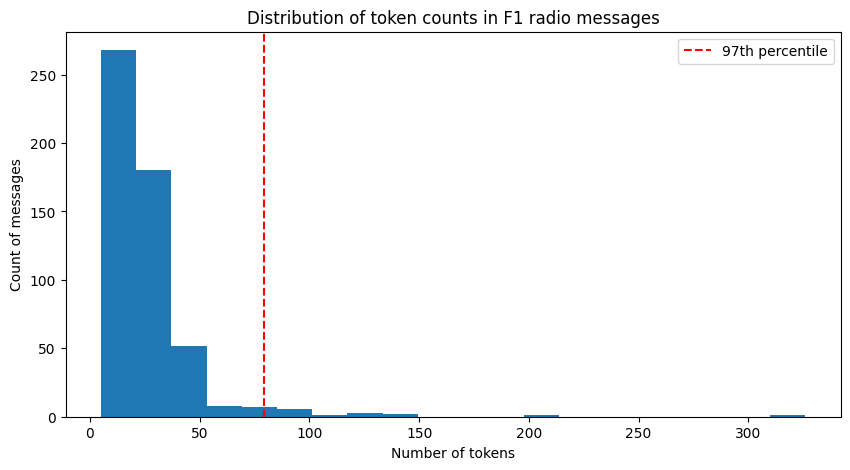

Setting max_length to 128


In [44]:
# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20)
plt.axvline(x=p97_tokens, color='r', linestyle='--', label='97th percentile')
plt.xlabel('Number of tokens')
plt.ylabel('Count of messages')
plt.title('Distribution of token counts in F1 radio messages')
plt.legend()
plt.show()

# Set max_length based on analysis
max_length = int(min(128, 2 * p97_tokens))  # Conservative value based on 97th percentile
print(f"Setting max_length to {max_length}")

#### 3.2.3 Tokenizing and making the encodings

In [45]:
# Cell 5: Tokenize the data directly
max_length = 128
#batch_size = 16
batch_size = 4
# Tokenize training data
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize validation data
val_encodings = tokenizer(
    list(val_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize test data
test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)



### Preparing the tokens for Pytorch

In [54]:
from transformers import AdamW, get_linear_schedule_with_warmup


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model.to(device)

Using device: cuda


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [55]:
# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

C:\Users\victo\AppData\Local\Temp\ipykernel_15468\439425289.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
C:\Users\victo\AppData\Local\Temp\ipykernel_15468\439425289.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels)
C:\Users\victo\AppData\Local\Temp\ipykernel_15468\439425289.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels)


In [56]:
# Create TensorDatasets
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)



In [57]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created DataLoaders with batch size: {batch_size}")
print(f"Each batch contains: {next(iter(train_dataloader))[0].shape[0]} samples")
print(f"Input shape: {next(iter(train_dataloader))[0].shape}")

from torch.amp import GradScaler, autocast
scaler = GradScaler()

Created DataLoaders with batch size: 4
Each batch contains: 4 samples
Input shape: torch.Size([4, 128])


---

## Setting up training process



---

### Auxiliar functions

In [58]:
def flat_accuracy(preds, labels):
    """
    Computes accuracy by comparing predictions with labels.
    
    Args:
        preds: Model prediction matrix (logits)
        labels: Vector of true labels
    
    Returns:
        float: Percentage of correct predictions
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [59]:
import datetime

def format_time(elapsed):
    """
    Formats elapsed time into a readable format.
    
    Args:
        elapsed: Time in seconds
        
    Returns:
        str: Time formatted as HH:MM:SS
    """
    return str(datetime.timedelta(seconds=int(round(elapsed))))

In [60]:
# Storage for training statistics
training_stats = []
best_val_accuracy = 0.0

### Hyperparameter tuning

In [ ]:
epochs = 12
learning_rate = 1e-5  # A bet less for a bigger model
weight_decay = 0.01
warmup_steps = int(0.1 * len(train_dataloader) * epochs)  # 10% steps for warmup

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Initialize optimizer
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  eps=1e-8,
                  weight_decay=weight_decay)

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                          num_warmup_steps=warmup_steps,
                                          num_training_steps=total_steps)
# Gradient accumulation for simulating bigger batch_size
gradient_accumulation_steps = 4  
# This simulates an effective batch_size  16

c:\Users\victo\miniconda3\envs\f1_strat_manager\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


---

### Class weights

In [62]:
# Calculating the 6 class weights
from sklearn.utils import compute_class_weight


unique_labels = np.unique(train_labels.numpy())
class_weights = compute_class_weight('balanced', classes=unique_labels, y=train_labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:")
for i, weight in enumerate(class_weights):
    intent_name = list(intent_mapping.keys())[list(intent_mapping.values()).index(i)]
    print(f"Class {i} ({intent_name}): {weight:.4f}")

# Loss function with weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

Class weights:
Class 0 (INFORMATION): 0.4167
Class 1 (PROBLEM): 0.8114
Class 2 (ORDER): 0.8222
Class 3 (STRATEGY): 2.5694
Class 4 (WARNING): 2.5694
Class 5 (QUESTION): 2.6812


---

### Training loop

In [65]:
total_t0 = time.time()

for epoch_i in range(epochs):
    print(f"\nEpoch {epoch_i + 1}/{epochs}")
    
    # Training
    model.train()
    total_train_loss = 0
    t0 = time.time()
    
    # Reset gradients at the beginning of each epoch
    optimizer.zero_grad()
    
    for step, batch in enumerate(train_dataloader):
        # Unpack batch and move to device
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Forward pass with mixed precision - corrected
        with autocast(device_type='cuda'):  # Specify 'cuda' as device_type
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, b_labels)
            loss = loss / gradient_accumulation_steps
        
        # Backward pass with mixed precision
        scaler.scale(loss).backward()
        
        # Update total loss
        total_train_loss += loss.item() * gradient_accumulation_steps
        
        # Update weights every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
    
    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Training loss: {avg_train_loss:.4f}")
    print(f"  Training time: {format_time(time.time() - t0)}")
    
    # Validation with mixed precision as well
    model.eval()
    val_accuracy = 0
    val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with autocast(device_type='cuda'):
                outputs = model(b_input_ids, attention_mask=b_attention_mask)
                logits = outputs.logits
                loss = loss_fn(logits, b_labels)
            
            val_loss += loss.item()
            val_accuracy += flat_accuracy(logits.cpu().numpy(), b_labels.cpu().numpy())
    
    avg_val_accuracy = val_accuracy / len(val_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)
    
    print(f"  Validation accuracy: {avg_val_accuracy:.4f}")
    print(f"  Validation loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        torch.save(model.state_dict(), '../../outputs/week4/models/best_roberta_large_intent_model.pt')
        print(f"  Saved new best model with accuracy: {best_val_accuracy:.4f}")



Epoch 1/12
  Training loss: 1.8010
  Training time: 0:00:10
  Validation accuracy: 0.4208
  Validation loss: 1.7626
  Saved new best model with accuracy: 0.4208

Epoch 2/12
  Training loss: 1.7758
  Training time: 0:00:10
  Validation accuracy: 0.4208
  Validation loss: 1.7858

Epoch 3/12
  Training loss: 1.7143
  Training time: 0:00:10
  Validation accuracy: 0.4250
  Validation loss: 1.6874
  Saved new best model with accuracy: 0.4250

Epoch 4/12
  Training loss: 1.6283
  Training time: 0:00:10
  Validation accuracy: 0.5375
  Validation loss: 1.6608
  Saved new best model with accuracy: 0.5375

Epoch 5/12
  Training loss: 1.3805
  Training time: 0:00:10
  Validation accuracy: 0.5458
  Validation loss: 1.5283
  Saved new best model with accuracy: 0.5458

Epoch 6/12
  Training loss: 0.9713
  Training time: 0:00:10
  Validation accuracy: 0.6208
  Validation loss: 1.2710
  Saved new best model with accuracy: 0.6208

Epoch 7/12
  Training loss: 0.5711
  Training time: 0:00:10
  Validation

---

### Training metrics

In [66]:
from sklearn.metrics import classification_report

# Pick all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        
        all_preds.extend(np.argmax(logits.cpu().numpy(), axis=1))
        all_labels.extend(b_labels.cpu().numpy())

# Make the classification report
intent_names = list(intent_mapping.keys())
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=intent_names))


Classification Report:
              precision    recall  f1-score   support

 INFORMATION       0.66      0.74      0.70        31
     PROBLEM       0.69      0.69      0.69        16
       ORDER       0.80      0.50      0.62        16
    STRATEGY       0.17      0.17      0.17         6
     WARNING       0.50      0.80      0.62         5
    QUESTION       1.00      0.80      0.89         5

    accuracy                           0.65        79
   macro avg       0.64      0.62      0.61        79
weighted avg       0.67      0.65      0.65        79



---

### Validation loop

In [67]:
# Switch to evaluation mode
model.eval()
val_accuracy = 0
val_loss = 0

# En la parte de validación:
with torch.no_grad():
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with autocast(device_type='cuda'):  # Especificar 'cuda' como device_type
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, b_labels)
        
        val_loss += loss.item()
        val_accuracy += flat_accuracy(logits.cpu().numpy(), b_labels.cpu().numpy())

In [68]:
# Calculate averages
avg_val_accuracy = val_accuracy / len(val_dataloader)
avg_val_loss = val_loss / len(val_dataloader)

print(f"  Validation accuracy: {avg_val_accuracy:.4f}")
print(f"  Validation loss: {avg_val_loss:.4f}")

# Store stats
training_stats.append({
    'epoch': epoch_i + 1,
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'val_accuracy': avg_val_accuracy
})


#################### NOTE: ONLY UNCOMMENT AND RUN IF BETTER METRICS ARE MET #########################
# Save best model
if avg_val_accuracy > best_val_accuracy:
    best_val_accuracy = avg_val_accuracy
    torch.save(model.state_dict(), '../../outputs/week4/models/best_roberta_intention_model.pt')
    print(f"  Saved new best model with accuracy: {best_val_accuracy:.4f}")

print(f"Training complete! Total time: {format_time(time.time() - total_t0)}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
######################################################################################################

  Validation accuracy: 0.6458
  Validation loss: 2.2457
Training complete! Total time: 0:02:28
Best validation accuracy: 0.6583


In [69]:
from sklearn.metrics import f1_score

# In validation loop:
predictions = np.argmax(logits.cpu().numpy(), axis=1)
labels = b_labels.cpu().numpy()
f1 = f1_score(labels, predictions, average='weighted')
print(f"  F1 score (weighted): {f1:.4f}")

  F1 score (weighted): 0.7778


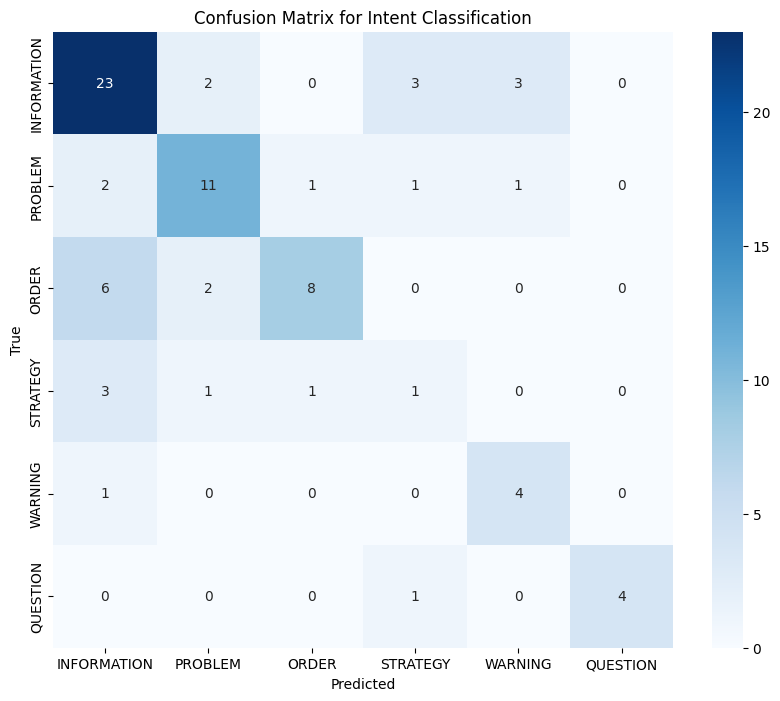


Classification Report:
              precision    recall  f1-score   support

 INFORMATION       0.66      0.74      0.70        31
     PROBLEM       0.69      0.69      0.69        16
       ORDER       0.80      0.50      0.62        16
    STRATEGY       0.17      0.17      0.17         6
     WARNING       0.50      0.80      0.62         5
    QUESTION       1.00      0.80      0.89         5

    accuracy                           0.65        79
   macro avg       0.64      0.62      0.61        79
weighted avg       0.67      0.65      0.65        79



In [70]:
# After validation:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        
        all_preds.extend(np.argmax(logits.cpu().numpy(), axis=1))
        all_labels.extend(b_labels.cpu().numpy())

# Get intent names for labels
intent_names = list(intent_mapping.keys())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_names,
            yticklabels=intent_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Intent Classification')
plt.show()

# Generate classification report with proper class names
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=intent_names))

# RoBERTa-large Intent Classification Model Performance

## Results Summary

### FIRST RUN
- **Best Validation Accuracy**: 65.83% (Epoch 7)
- **Weighted F1 Score**: 77.78%
- **Training Time**: 2:28 (12 epochs)

## Class Performance
| Intent Class | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| INFORMATION | 0.66      | 0.74   | 0.70     | 31      |
| PROBLEM     | 0.69      | 0.69   | 0.69     | 16      |
| ORDER       | 0.80      | 0.50   | 0.62     | 16      |
| STRATEGY    | 0.17      | 0.17   | 0.17     | 6       |
| WARNING     | 0.50      | 0.80   | 0.62     | 5       |
| QUESTION    | 1.00      | 0.80   | 0.89     | 5       |

## Analysis
The model shows promising performance with a 65.83% accuracy on a challenging 6-class classification task. Performance varies significantly across intent classes, with QUESTION achieving excellent results (89% F1) while STRATEGY performs poorly (17% F1). The confusion matrix reveals that ORDER messages are frequently misclassified as INFORMATION, suggesting some semantic overlap. Training dynamics indicate overfitting begins after epoch 7, with increasing validation loss despite decreasing training loss.

RoBERTa-large demonstrates good potential for intent classification with appropriate fine-tuning, though the STRATEGY class needs improvement, possibly through additional examples or more targeted class weighting.